In [1]:
!pip install pm4py
!pip install optuna

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.8 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=5af165ae2713667e45fc57e3aa4bdd464c4639c93d5e5dfdd122970f34debcfb
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [2]:
log_url = "https://data.4tu.nl/datasets/6a0a26d2-82d0-4018-b1cd-89afb0e8627f"

In [2]:
import pm4py
import optuna
import pandas as pd
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristic_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation.replay_fitness import algorithm as fitness_evaluator
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.utils.check_soundness import check_easy_soundness_net_in_fin_marking
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.objects.conversion.log import converter as log_converter

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [7]:
# Domestic declarations log
log = pm4py.read_xes('DomesticDeclarations.xes')

/usr/local/lib/python3.10/dist-packages/pm4py/util/dt_parsing/parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

In [8]:
# Italian helpdesk log
data = pd.read_csv('finale.csv')
data.rename(columns={
    'Case ID': 'case:concept:name',
    'Activity': 'concept:name',
    'Complete Timestamp': 'time:timestamp'
}, inplace=True)

# Convert the timestamp column to datetime format
data['time:timestamp'] = pd.to_datetime(data['time:timestamp'])

# Ensure the activity names are treated as strings
data['concept:name'] = data['concept:name'].astype(str)
log = log_converter.apply(data, variant=log_converter.Variants.TO_EVENT_LOG)

In [5]:
log

[{'attributes': {'concept:name': 'Case 1'}, 'events': [{'concept:name': 'Assign seriousness', 'Resource': 'Value 1', 'time:timestamp': Timestamp('2012-10-09 14:50:17'), 'Variant': 'Variant 12', 'Variant index': 12, 'Variant.1': 'Variant 12', 'seriousness': 'Value 1', 'customer': 'Value 1', 'product': 'Value 1', 'responsible_section': 'Value 1', 'seriousness_2': 'Value 1', 'service_level': 'Value 1', 'service_type': 'Value 1', 'support_section': 'Value 1', 'workgroup': 'Value 1'}, '..', {'concept:name': 'Closed', 'Resource': 'Value 3', 'time:timestamp': Timestamp('2012-11-09 12:54:39'), 'Variant': 'Variant 12', 'Variant index': 12, 'Variant.1': 'Variant 12', 'seriousness': 'Value 1', 'customer': 'Value 1', 'product': 'Value 1', 'responsible_section': 'Value 1', 'seriousness_2': 'Value 1', 'service_level': 'Value 2', 'service_type': 'Value 1', 'support_section': 'Value 1', 'workgroup': 'Value 1'}]}, '....', {'attributes': {'concept:name': 'Case 4580'}, 'events': [{'concept:name': 'Take i

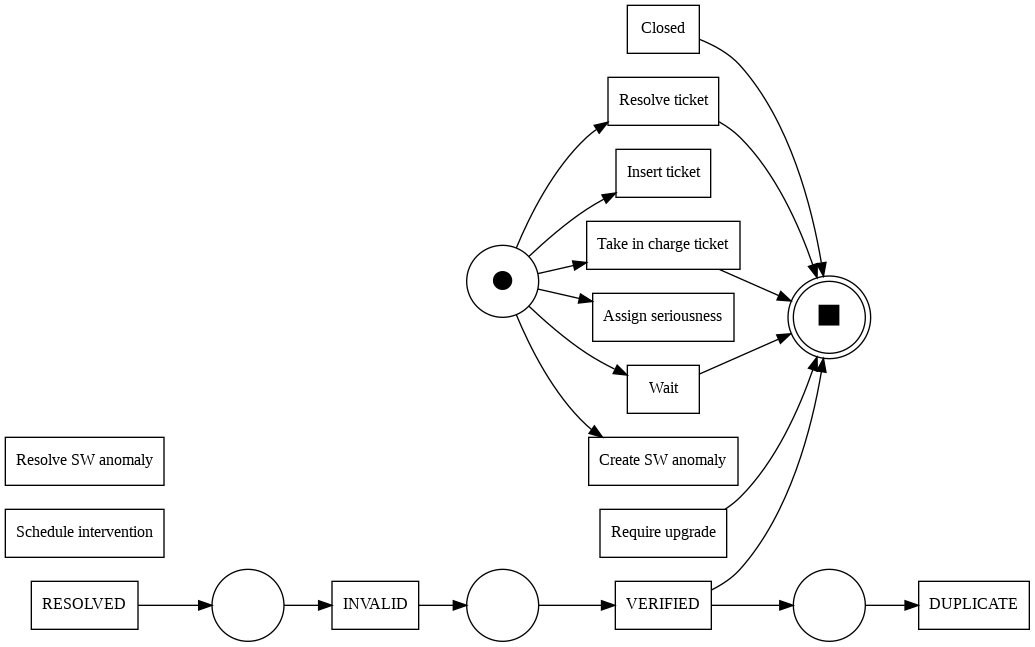

In [6]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

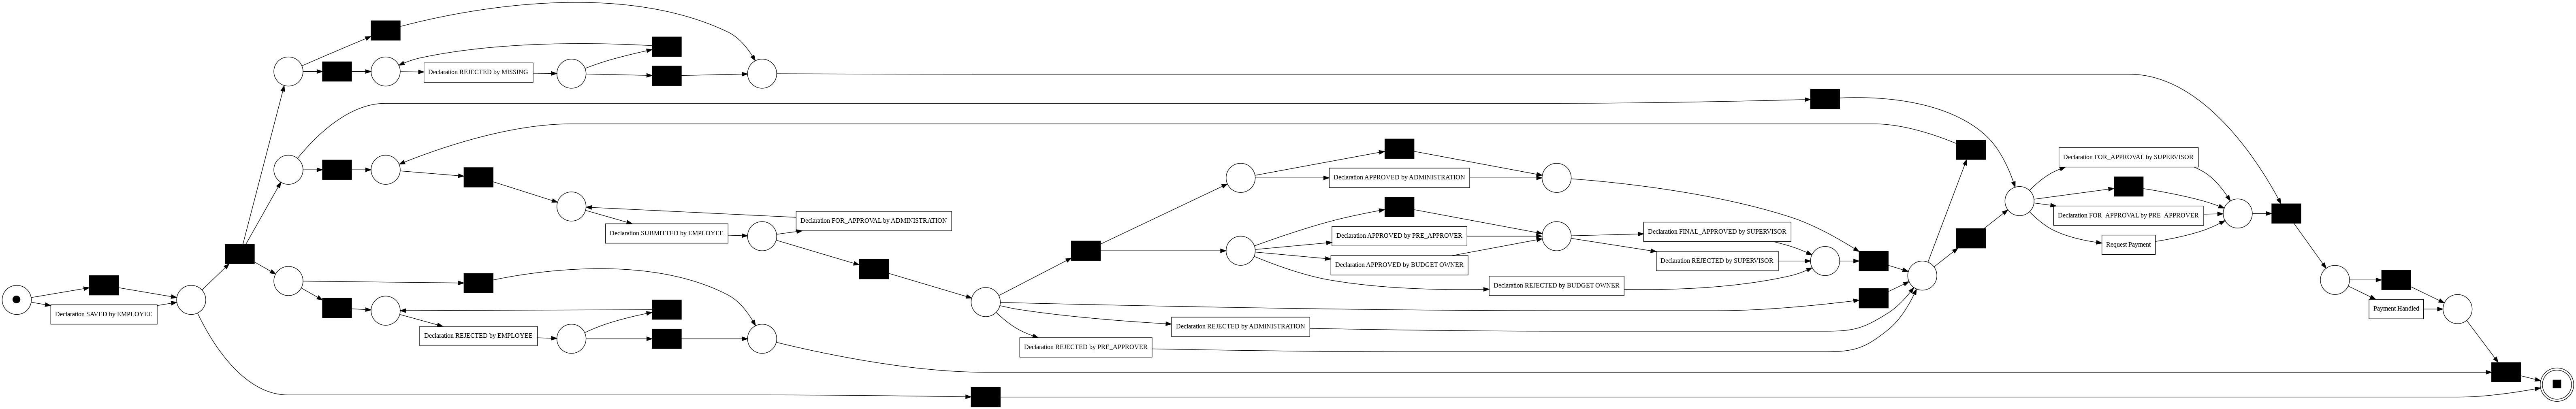

In [12]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

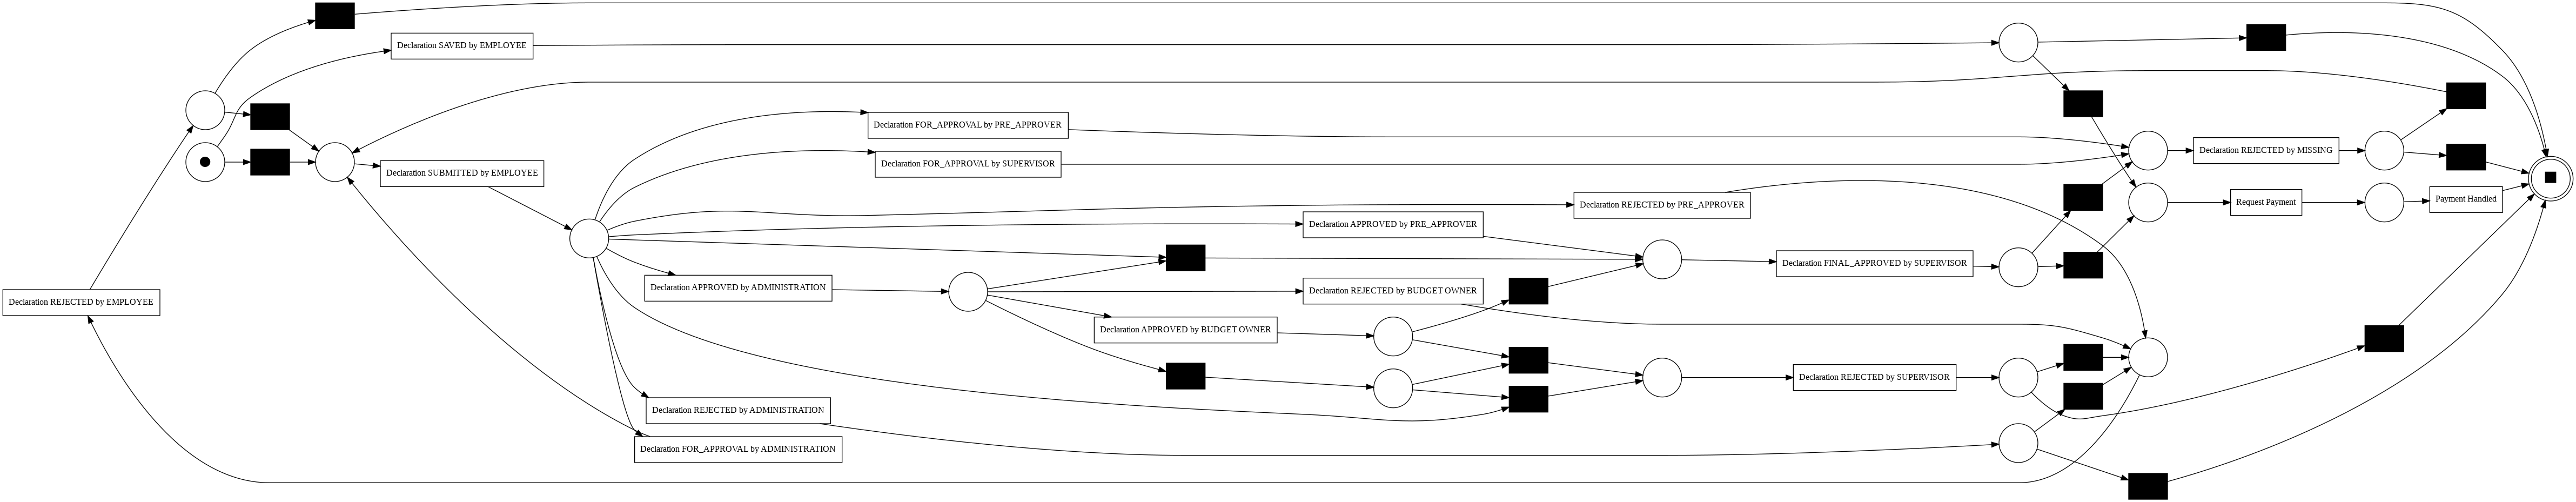

In [13]:
net, initial_marking, final_marking = pm4py.discover_petri_net_heuristics(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

In [9]:
"""
Functions for evaluation
"""

def evaluate_fitness(net, initial_marking, final_marking, log):
    # Check if the produced net has sound structure or not
    is_sound = check_easy_soundness_net_in_fin_marking(net, initial_marking, final_marking)

    if is_sound:
        fitness_results = fitness_evaluator.apply(
            log, net, initial_marking, final_marking, variant=fitness_evaluator.ALIGNMENT_BASED
        )
    else:
        fitness_results = fitness_evaluator.apply(
            log, net, initial_marking, final_marking, variant=fitness_evaluator.TOKEN_BASED
        )

    return fitness_results["log_fitness"]

# Simplicity (placeholder for simplicity metric)
def evaluate_simplicity(net):
    # PM4Py does not directly compute simplicity; use model complexity as a proxy
    num_places = len(net.places)
    num_transitions = len(net.transitions)
    num_arcs = len(net.arcs)
    simplicity = 1 / (num_places + num_transitions + num_arcs)  # Example metric
    return simplicity

# Generalization (placeholder for generalization metric)
def evaluate_generalization(net, log):
    # PM4Py does not directly compute generalization; implement custom logic if needed
    return 0.8  # Example: Return a constant value for now

In [10]:
def apply_alpha(log):
    net, initial_marking, final_marking = alpha_miner.apply(log)
    return net, initial_marking, final_marking

def apply_heuristic(log, parameters):
    net, initial_marking, final_marking = heuristic_miner.apply(log, parameters=parameters)
    return net, initial_marking, final_marking

def apply_inductive(log, noise_threshold=0.0):
    parameters = {"noise_threshold": noise_threshold}
    process_tree = inductive_miner.apply(log, parameters=parameters)

    # Convert the Process Tree to a Petri net
    net, initial_marking, final_marking = pt_converter.apply(process_tree)
    return net, initial_marking, final_marking

In [11]:
def objective(trial):
    # Select an algorithm
    algorithm = trial.suggest_categorical("algorithm", ["alpha", "heuristic", "inductive"])

    # Apply the selected algorithm
    if algorithm == "alpha":
        net, initial_marking, final_marking = apply_alpha(log)
    elif algorithm == "heuristic":
        dependency_thresh = trial.suggest_float("dependency_thresh", 0.0, 1.0)
        and_measure_thresh = trial.suggest_float("and_measure_thresh", 0.5, 1.0)
        loop_two_thresh = trial.suggest_float("loop_two_thresh", 0.0, 1.0)
        parameters = {
        "dependency_thresh": dependency_thresh,
        "and_measure_thresh": and_measure_thresh,
        "loop_two_thresh": loop_two_thresh
        }
        net, initial_marking, final_marking = apply_heuristic(log, parameters=parameters)
    elif algorithm == "inductive":
        noise_threshold = trial.suggest_float("noise_threshold", 0.0, 0.3)
        net, initial_marking, final_marking = apply_inductive(log, noise_threshold=noise_threshold)

    # Evaluate metrics
    fitness = evaluate_fitness(net, initial_marking, final_marking, log)
    simplicity = evaluate_simplicity(net)
    generalization = evaluate_generalization(net, log)

    # Combine metrics (weighted sum as an example)
    combined_score = fitness * 0.6 + simplicity * 0.2 + generalization * 0.2
    return combined_score

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-12-14 13:41:00,015] A new study created in memory with name: no-name-84c302c6-bb5d-4be0-bb63-06c316317a69


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:41:13,582] Trial 0 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.21103525985310287}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:41:14,696] Trial 1 finished with value: 0.48178923755597625 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:41:35,097] Trial 2 finished with value: 0.5980252871511447 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.6440577530909726}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:41:48,135] Trial 3 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.1209600902157522}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:42:00,975] Trial 4 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.08510302447630792}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:42:02,559] Trial 5 finished with value: 0.48178923755597625 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:42:18,833] Trial 6 finished with value: 0.597924683170034 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.6010090176116776}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:42:19,979] Trial 7 finished with value: 0.48178923755597625 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:42:28,244] Trial 8 finished with value: 0.5698438930326111 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.1564812847844792}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:42:37,287] Trial 9 finished with value: 0.5698438930326111 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.34174254172869456}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:42:50,839] Trial 10 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.29690920787561315}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:43:04,581] Trial 11 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.19217266117923798}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:43:19,862] Trial 12 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.16820396552993194}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:43:33,493] Trial 13 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.00021505580285088866}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:43:47,069] Trial 14 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.240401666769712}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:44:00,326] Trial 15 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.11495255255808849}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:44:14,405] Trial 16 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.06722713864841402}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:44:28,299] Trial 17 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.20625620355815202}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:44:42,369] Trial 18 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.12222439480276018}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:44:43,527] Trial 19 finished with value: 0.48178923755597625 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:44:56,984] Trial 20 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.23819995966151464}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:45:14,647] Trial 21 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.07007127215153149}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:45:28,597] Trial 22 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.08139461888392005}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:45:42,685] Trial 23 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.13603756836796765}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:45:56,519] Trial 24 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.024807078513129632}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:46:10,552] Trial 25 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.0977819456174839}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:46:24,211] Trial 26 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.15535046505921266}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:46:38,803] Trial 27 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.048303934931394565}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:46:48,183] Trial 28 finished with value: 0.5987292255362962 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.9588897065099021}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:46:49,223] Trial 29 finished with value: 0.48178923755597625 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:46:50,343] Trial 30 finished with value: 0.48178923755597625 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:47:05,155] Trial 31 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.29480583734784965}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:47:19,936] Trial 32 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2689884159778629}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:47:33,985] Trial 33 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2993909657034217}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:47:47,672] Trial 34 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.18410280170395185}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:47:56,733] Trial 35 finished with value: 0.5697837042371279 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.04046107296334589}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:47:58,205] Trial 36 finished with value: 0.48178923755597625 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:48:12,036] Trial 37 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.23050384572258187}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:48:21,330] Trial 38 finished with value: 0.5987338661619701 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.9782470533747623}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:48:35,492] Trial 39 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.10347872236751268}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:48:48,896] Trial 40 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.14062750836752144}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:49:02,562] Trial 41 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.19457444505343824}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:49:16,436] Trial 42 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.21601434345539255}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:49:30,396] Trial 43 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.268819822221427}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:49:44,378] Trial 44 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.174793628327741}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:50:48,453] Trial 45 finished with value: 0.5698312091158175 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.3583574630308215}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:51:01,715] Trial 46 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.16170187904457872}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:51:15,452] Trial 47 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.25538298145986393}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:51:16,612] Trial 48 finished with value: 0.48178923755597625 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7608259767621316.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 13:51:30,430] Trial 49 finished with value: 0.7608259767621316 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.13341636185812897}. Best is trial 0 with value: 0.7608259767621316.


Best algorithm and parameters:
{'algorithm': 'inductive', 'noise_threshold': 0.08124162210409376}


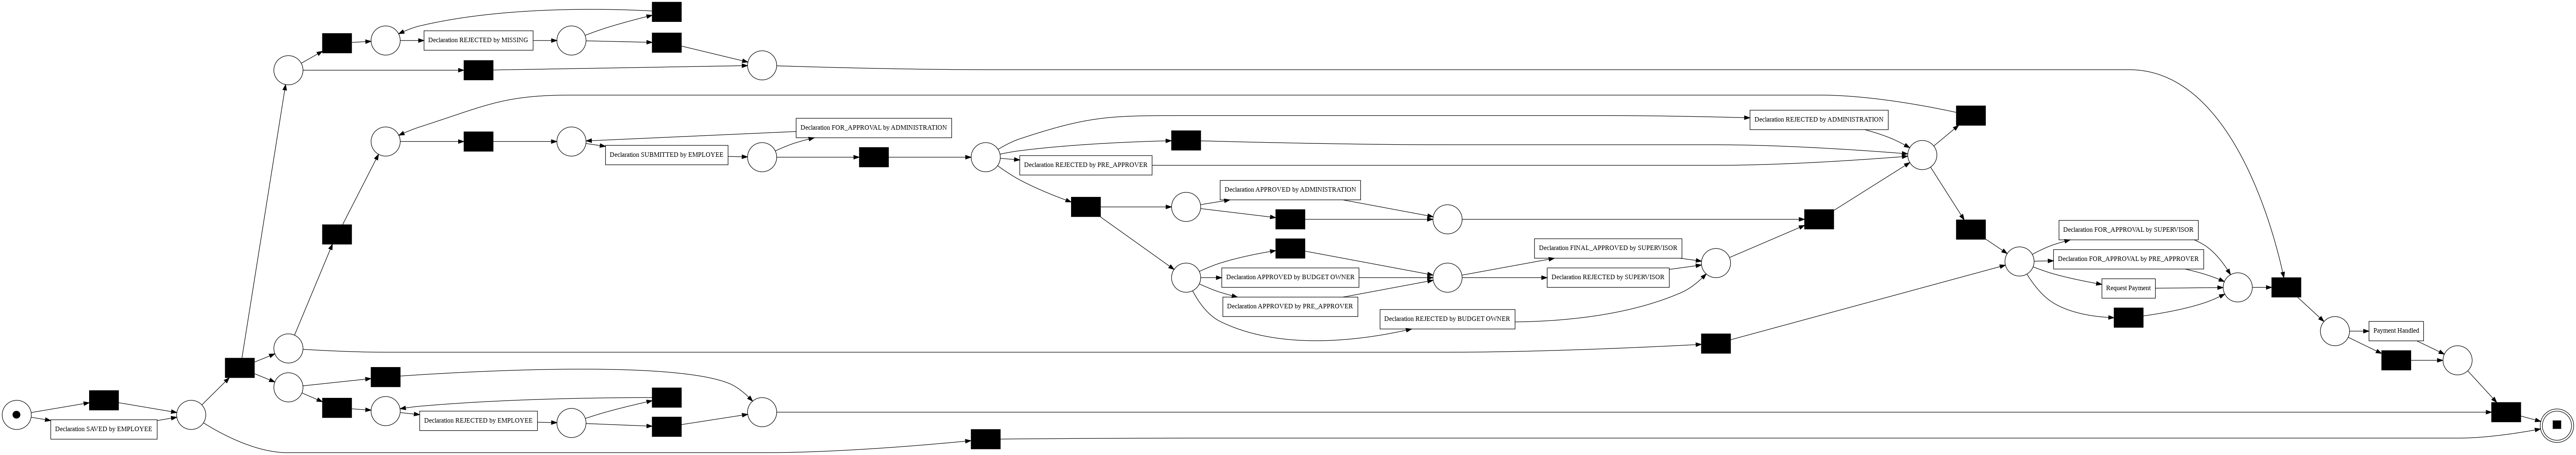

In [39]:
print("Best algorithm and parameters:")
print(study.best_params)

# Apply the best model to get the final process model
best_algorithm = study.best_params["algorithm"]
if best_algorithm == "alpha":
    final_net, final_initial_marking, final_final_marking = apply_alpha(log)
elif best_algorithm == "heuristic":
    best_dependency_thresh = study.best_params["dependency_thresh"]
    final_net, final_initial_marking, final_final_marking = apply_heuristic(log, dependency_thresh=best_dependency_thresh)
elif best_algorithm == "inductive":
    best_noise_threshold = study.best_params["noise_threshold"]
    final_net, final_initial_marking, final_final_marking = apply_inductive(log, noise_threshold=best_noise_threshold)

# Visualize the best model
gviz = pn_visualizer.apply(final_net, final_initial_marking, final_final_marking)
pn_visualizer.view(gviz)